# 🎯 SimCLR Fine-tuning + YOLOv12 Object Detection

**Assignment 2: Self-Supervised Learning - Phase 2: Fine-tuning**

This notebook demonstrates how to use the **pretrained SimCLR backbone** for downstream object detection with **YOLOv12**. Following the teacher's example pattern: SimCLR SSL → YOLO detector fine-tuning.

---

## 📋 Pipeline Overview

| # | Step | Description | Output |
|---|------|-------------|--------|
| **1** | Environment Setup | Install ultralytics, configure GPU | Ready environment |
| **2** | Load SimCLR Backbone | Load pretrained SSL weights | Backbone weights |
| **3** | Inject into YOLOv12 | Replace YOLO backbone with SimCLR weights | Initialized detector |
| **4** | Fine-tune Detector | Train YOLOv12 on Brain MRI dataset | `best.pt` weights |
| **5** | Evaluation | Compute mAP, precision, recall | Metrics |
| **6** | Visualization | Predictions with bounding boxes & counts | Visual results |
| **7** | Confusion Matrix | Display training analysis | Plots |

---

## 📚 Table of Contents

1. [Introduction](#1-introduction)
2. [Environment Setup](#2-environment-setup)
3. [Configuration](#3-configuration)
4. [Load Pretrained Encoder](#4-load-pretrained-encoder)
5. [Data Loading](#5-data-loading)
6. [Linear Evaluation (Frozen Encoder)](#6-linear-evaluation-frozen-encoder)
7. [Full Fine-tuning](#7-full-fine-tuning)
8. [Training Curves & Analysis](#8-training-curves--analysis)
9. [Comprehensive Evaluation](#9-comprehensive-evaluation)
10. [YOLO Object Detection Integration](#10-yolo-object-detection-integration)
11. [Results Summary](#11-results-summary)

---

## 1. Introduction

### Two-Stage Transfer Learning

SimCLR uses a two-stage approach:

**Stage 1: Pretraining (Previous Notebook)**
- Learn visual representations using contrastive learning
- No labels required
- Output: Pretrained encoder weights

**Stage 2: Fine-tuning (This Notebook)**
- Load pretrained encoder
- Add classification head
- Train on labeled data

### Evaluation Protocols

We evaluate using two protocols:

1. **Linear Evaluation**: Freeze encoder, train only a linear classifier
   - Tests feature quality without modification
   - Standard benchmark for self-supervised learning

2. **Full Fine-tuning**: Train entire network (encoder + classifier)
   - Achieves best downstream performance
   - Adapts features to the specific task

```
┌───────────────────────────────────────────────────────────┐
│                  Pretrained Encoder                       │
│                    (from Stage 1)                         │
├───────────────────────────────────────────────────────────┤
│   Linear Eval: ❄️ Frozen  │  Fine-tune: 🔥 Trainable     │
└───────────────────────────────────────────────────────────┘
                           │
                           ▼
                 ┌───────────────────┐
                 │  Classification   │
                 │       Head        │
                 │   (Always Train)  │
                 └───────────────────┘
                           │
                           ▼
                   Class Predictions
```

## 2. Environment Setup

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image

# Sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)

# Seaborn for better plots
try:
    import seaborn as sns
    sns.set_style('whitegrid')
    HAS_SEABORN = True
except:
    HAS_SEABORN = False

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(42)

# ==================================
# DEVICE SELECTION (CUDA > MPS > CPU)
# ==================================
def get_device():
    """Get the best available device."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"🖥️  Device: CUDA ({torch.cuda.get_device_name(0)})")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f"🖥️  Device: MPS (Apple Silicon)")
    else:
        device = torch.device('cpu')
        print(f"🖥️  Device: CPU")
    return device

device = get_device()

# Environment detection
IS_KAGGLE = os.path.exists('/kaggle/input')
IS_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False

print(f"📍 Environment: {'🌐 Kaggle' if IS_KAGGLE else '🔬 Colab' if IS_COLAB else '💻 Local'}")
print(f"🐍 PyTorch Version: {torch.__version__}")
print("✅ All imports successful!")

🖥️  Device: CUDA (Tesla T4)
📍 Environment: 🌐 Kaggle
🐍 PyTorch Version: 2.6.0+cu124
✅ All imports successful!


## 3. Configuration

In [2]:
class Config:
    """SimCLR Fine-tuning + YOLO Integration Configuration"""
    
    # ==================================
    # PATH CONFIGURATION
    # ==================================
    if IS_KAGGLE:
        DATASET_NAME = 'brain-mri-split-dataset-v2/brain-mri-split-dataset-v2'
        DATA_DIR = Path(f'/kaggle/input/{DATASET_NAME}/dataset')
        DATA_YAML = Path(f'/kaggle/input/{DATASET_NAME}/data.yaml')
        # SimCLR pretrained backbone
        PRETRAINED_PATH = Path('/kaggle/input/03-1-simclr-pretrainingdcec1c9968/03_1_SimCLR_Pretraining/simclr_backbone.pth')
        # YOLOv12 weights included in dataset
        YOLOV12_WEIGHTS = Path(f'/kaggle/input/{DATASET_NAME}/yolov12-best.pt')
        OUTPUT_DIR = Path('/kaggle/working/03_2_SimCLR_Finetuning')
    else:
        DATA_DIR = Path('e:/EWU University/10th Semester/CSE475/Brain MRI/brain-mri-split-dataset-v2/dataset')
        DATA_YAML = Path('e:/EWU University/10th Semester/CSE475/Brain MRI/brain-mri-split-dataset-v2/data.yaml')
        PRETRAINED_PATH = Path('e:/EWU University/10th Semester/CSE475/Brain MRI/Assignment V2/outputs/03_1_SimCLR_Pretraining/simclr_backbone.pth')
        YOLOV12_WEIGHTS = Path('e:/EWU University/10th Semester/CSE475/Brain MRI/brain-mri-split-dataset-v2/yolov12-best.pt')
        OUTPUT_DIR = Path('e:/EWU University/10th Semester/CSE475/Brain MRI/Assignment V2/outputs/03_2_SimCLR_Finetuning')
    
    # Model
    BACKBONE = 'resnet18'
    FEATURE_DIM = 512  # ResNet18 feature dimension
    
    # Classes
    CLASS_NAMES = ['cct', 'ifc', 'uas']
    NUM_CLASSES = 3
    
    # YOLO Fine-tuning 
    YOLO_EPOCHS = 20
    YOLO_IMGSZ = 640
    YOLO_BATCH = 8
    
    # Training
    EPOCHS_LINEAR = 30     # Epochs for linear evaluation
    EPOCHS_FINETUNE = 30   # Epochs for full fine-tuning
    BATCH_SIZE = 32
    LEARNING_RATE_LINEAR = 1e-3
    LEARNING_RATE_FINETUNE = 1e-4  # Lower LR for fine-tuning
    WEIGHT_DECAY = 1e-4
    
    # Image
    IMG_SIZE = 224

config = Config()
config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ==================================
# PRINT CONFIGURATION
# ==================================
print("=" * 70)
print("📋 SIMCLR FINE-TUNING CONFIGURATION")
print("=" * 70)
print(f"  📍 Environment:      {'🌐 Kaggle' if IS_KAGGLE else '💻 Local'}")
print(f"  📂 Data Directory:   {config.DATA_DIR}")
print(f"  🔧 Pretrained Model: {config.PRETRAINED_PATH}")
print(f"  📁 Output Directory: {config.OUTPUT_DIR}")
print(f"  🏗️  Backbone:          {config.BACKBONE}")
print(f"  🏷️  Classes:           {config.CLASS_NAMES}")
print(f"  🔄 Linear Epochs:    {config.EPOCHS_LINEAR}")
print(f"  🔄 Finetune Epochs:  {config.EPOCHS_FINETUNE}")
print("=" * 70)

# Verify pretrained model exists
if config.PRETRAINED_PATH.exists():
    print(f"\n✅ Pretrained model found!")
else:
    print(f"\n⚠️  WARNING: Pretrained model not found at {config.PRETRAINED_PATH}")
    print("   The model will use random initialization.")
    print("   For best results, run 03_1_SimCLR_Pretraining.ipynb first.")

📋 SIMCLR FINE-TUNING CONFIGURATION
  📍 Environment:      🌐 Kaggle
  📂 Data Directory:   /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset
  🔧 Pretrained Model: /kaggle/input/03-1-simclr-pretrainingdcec1c9968/03_1_SimCLR_Pretraining/simclr_backbone.pth
  📁 Output Directory: /kaggle/working/03_2_SimCLR_Finetuning
  🏗️  Backbone:          resnet18
  🏷️  Classes:           ['cct', 'ifc', 'uas']
  🔄 Linear Epochs:    30
  🔄 Finetune Epochs:  30

✅ Pretrained model found!


## 4. Load Pretrained Encoder

In [3]:
def create_encoder(backbone='resnet18', pretrained_path=None):
    """
    Create encoder and load pretrained SimCLR weights.
    """
    # Create backbone
    if backbone == 'resnet18':
        encoder = models.resnet18(pretrained=False)
        feature_dim = 512
    elif backbone == 'resnet34':
        encoder = models.resnet34(pretrained=False)
        feature_dim = 512
    elif backbone == 'resnet50':
        encoder = models.resnet50(pretrained=False)
        feature_dim = 2048
    else:
        raise ValueError(f"Unknown backbone: {backbone}")
    
    # Remove final FC layer
    encoder.fc = nn.Identity()
    
    # Load pretrained weights if available
    if pretrained_path and Path(pretrained_path).exists():
        print(f"📂 Loading pretrained weights from: {pretrained_path}")
        checkpoint = torch.load(pretrained_path, map_location=device)
        
        if 'encoder_state_dict' in checkpoint:
            encoder.load_state_dict(checkpoint['encoder_state_dict'])
            print("✅ Loaded encoder_state_dict successfully!")
        else:
            encoder.load_state_dict(checkpoint)
            print("✅ Loaded state_dict successfully!")
        
        if 'config' in checkpoint:
            print(f"   Pretraining config: {checkpoint['config']}")
    else:
        print(f"⚠️ Pretrained weights not found at {pretrained_path}")
        print("   Using random initialization (for demonstration)")
    
    return encoder, feature_dim


# Load encoder
encoder, feature_dim = create_encoder(
    backbone=config.BACKBONE,
    pretrained_path=config.PRETRAINED_PATH
)

📂 Loading pretrained weights from: /kaggle/input/03-1-simclr-pretrainingdcec1c9968/03_1_SimCLR_Pretraining/simclr_backbone.pth
✅ Loaded encoder_state_dict successfully!
   Pretraining config: {'img_size': 224, 'projection_dim': 128, 'hidden_dim': 512, 'temperature': 0.2, 'epochs_trained': 100}


In [4]:
class ClassificationModel(nn.Module):
    """
    Classification model: Pretrained Encoder + Classification Head
    
    Can operate in two modes:
    - freeze_encoder=True: Linear evaluation (only train classifier)
    - freeze_encoder=False: Full fine-tuning (train everything)
    """
    
    def __init__(self, encoder, feature_dim, num_classes, freeze_encoder=True):
        super(ClassificationModel, self).__init__()
        
        self.encoder = encoder
        self.feature_dim = feature_dim
        
        # Freeze or unfreeze encoder
        self.set_encoder_trainable(not freeze_encoder)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def set_encoder_trainable(self, trainable):
        """Freeze or unfreeze encoder parameters."""
        for param in self.encoder.parameters():
            param.requires_grad = trainable
    
    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits
    
    def extract_features(self, x):
        """Extract features without classification."""
        return self.encoder(x)

print("✅ Model classes defined!")

✅ Model classes defined!


## 5. Data Loading

In [5]:
class LabeledDataset(Dataset):
    """
    Dataset with labels for classification.
    Reads class ID from YOLO format label files.
    """
    
    def __init__(self, img_dir, lbl_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.lbl_dir = Path(lbl_dir)
        self.image_files = (
            list(self.img_dir.glob('*.jpg')) + 
            list(self.img_dir.glob('*.png')) +
            list(self.img_dir.glob('*.jpeg'))
        )
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Get label from annotation file
        lbl_path = self.lbl_dir / (img_path.stem + '.txt')
        label = 0  # Default
        if lbl_path.exists():
            with open(lbl_path, 'r') as f:
                lines = f.readlines()
                if lines:
                    label = int(lines[0].strip().split()[0])
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


# Transforms
train_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = LabeledDataset(
    config.DATA_DIR / 'train' / 'images',
    config.DATA_DIR / 'train' / 'labels',
    transform=train_transform
)

val_dataset = LabeledDataset(
    config.DATA_DIR / 'valid' / 'images',
    config.DATA_DIR / 'valid' / 'labels',
    transform=val_transform
)

test_dataset = LabeledDataset(
    config.DATA_DIR / 'test' / 'images',
    config.DATA_DIR / 'test' / 'labels',
    transform=val_transform
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)

print(f"📊 Dataset sizes:")
print(f"   Train: {len(train_dataset)} images")
print(f"   Validation: {len(val_dataset)} images")
print(f"   Test: {len(test_dataset)} images")

📊 Dataset sizes:
   Train: 1810 images
   Validation: 226 images
   Test: 227 images


## 6. Linear Evaluation (Frozen Encoder)

First, we evaluate the quality of pretrained features by training only a linear classifier on top of frozen features. This is the standard benchmark for self-supervised learning.

In [6]:
def train_one_epoch(model, loader, criterion, optimizer):
    """Train for one epoch."""
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate on a dataset."""
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    return total_loss / total, correct / total, np.array(all_preds), np.array(all_labels)


def train_classifier(model, train_loader, val_loader, config, epochs, lr, name="Model"):
    """
    Full training loop with history tracking.
    """
    criterion = nn.CrossEntropyLoss()
    
    # Only optimize trainable parameters
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(trainable_params, lr=lr, weight_decay=config.WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    history = {
        'epoch': [], 'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'lr': []
    }
    
    best_val_acc = 0
    print(f"\n🎯 Training {name}...")
    print(f"   Trainable parameters: {sum(p.numel() for p in trainable_params):,}")
    print("="*60)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
        
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        
        # Log
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), config.OUTPUT_DIR / f'{name.lower().replace(" ", "_")}_best.pth')
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"  Epoch [{epoch+1:3d}/{epochs}] | "
                  f"Train: {train_acc*100:.2f}% | Val: {val_acc*100:.2f}% | "
                  f"Loss: {val_loss:.4f}")
    
    print("="*60)
    print(f"✅ {name} - Best Val Accuracy: {best_val_acc*100:.2f}%")
    
    return history, best_val_acc

print("✅ Training functions defined!")

✅ Training functions defined!


In [7]:
# Create model for Linear Evaluation
# Reload encoder fresh
encoder_linear, _ = create_encoder(config.BACKBONE, config.PRETRAINED_PATH)

model_linear = ClassificationModel(
    encoder=encoder_linear,
    feature_dim=config.FEATURE_DIM,
    num_classes=config.NUM_CLASSES,
    freeze_encoder=True  # Freeze for linear evaluation
).to(device)

print("\n🔒 LINEAR EVALUATION (Frozen Encoder)")
print(f"   Encoder: ❄️ Frozen")
print(f"   Classifier: 🔥 Trainable")

# Train
history_linear, best_acc_linear = train_classifier(
    model_linear, train_loader, val_loader, config,
    epochs=config.EPOCHS_LINEAR,
    lr=config.LEARNING_RATE_LINEAR,
    name="Linear_Eval"
)

📂 Loading pretrained weights from: /kaggle/input/03-1-simclr-pretrainingdcec1c9968/03_1_SimCLR_Pretraining/simclr_backbone.pth
✅ Loaded encoder_state_dict successfully!
   Pretraining config: {'img_size': 224, 'projection_dim': 128, 'hidden_dim': 512, 'temperature': 0.2, 'epochs_trained': 100}

🔒 LINEAR EVALUATION (Frozen Encoder)
   Encoder: ❄️ Frozen
   Classifier: 🔥 Trainable

🎯 Training Linear_Eval...
   Trainable parameters: 132,099
  Epoch [  1/30] | Train: 50.33% | Val: 53.54% | Loss: 0.9371
  Epoch [ 10/30] | Train: 55.86% | Val: 51.77% | Loss: 0.9045
  Epoch [ 20/30] | Train: 58.67% | Val: 55.31% | Loss: 0.8618
  Epoch [ 30/30] | Train: 61.49% | Val: 57.52% | Loss: 0.8585
✅ Linear_Eval - Best Val Accuracy: 57.52%


## 7. Full Fine-tuning

Now we fine-tune the entire network (encoder + classifier) for best performance.

In [8]:
# Create model for Full Fine-tuning
encoder_finetune, _ = create_encoder(config.BACKBONE, config.PRETRAINED_PATH)

model_finetune = ClassificationModel(
    encoder=encoder_finetune,
    feature_dim=config.FEATURE_DIM,
    num_classes=config.NUM_CLASSES,
    freeze_encoder=False  # Unfreeze for fine-tuning
).to(device)

print("\n🔥 FULL FINE-TUNING")
print(f"   Encoder: 🔥 Trainable")
print(f"   Classifier: 🔥 Trainable")

# Train
history_finetune, best_acc_finetune = train_classifier(
    model_finetune, train_loader, val_loader, config,
    epochs=config.EPOCHS_FINETUNE,
    lr=config.LEARNING_RATE_FINETUNE,
    name="Full_Finetune"
)

📂 Loading pretrained weights from: /kaggle/input/03-1-simclr-pretrainingdcec1c9968/03_1_SimCLR_Pretraining/simclr_backbone.pth
✅ Loaded encoder_state_dict successfully!
   Pretraining config: {'img_size': 224, 'projection_dim': 128, 'hidden_dim': 512, 'temperature': 0.2, 'epochs_trained': 100}

🔥 FULL FINE-TUNING
   Encoder: 🔥 Trainable
   Classifier: 🔥 Trainable

🎯 Training Full_Finetune...
   Trainable parameters: 11,308,611
  Epoch [  1/30] | Train: 51.33% | Val: 54.87% | Loss: 0.9258
  Epoch [ 10/30] | Train: 88.01% | Val: 79.20% | Loss: 0.4591
  Epoch [ 20/30] | Train: 97.85% | Val: 92.04% | Loss: 0.2549
  Epoch [ 30/30] | Train: 99.12% | Val: 92.04% | Loss: 0.2614
✅ Full_Finetune - Best Val Accuracy: 92.04%


## 8. Training Curves & Analysis

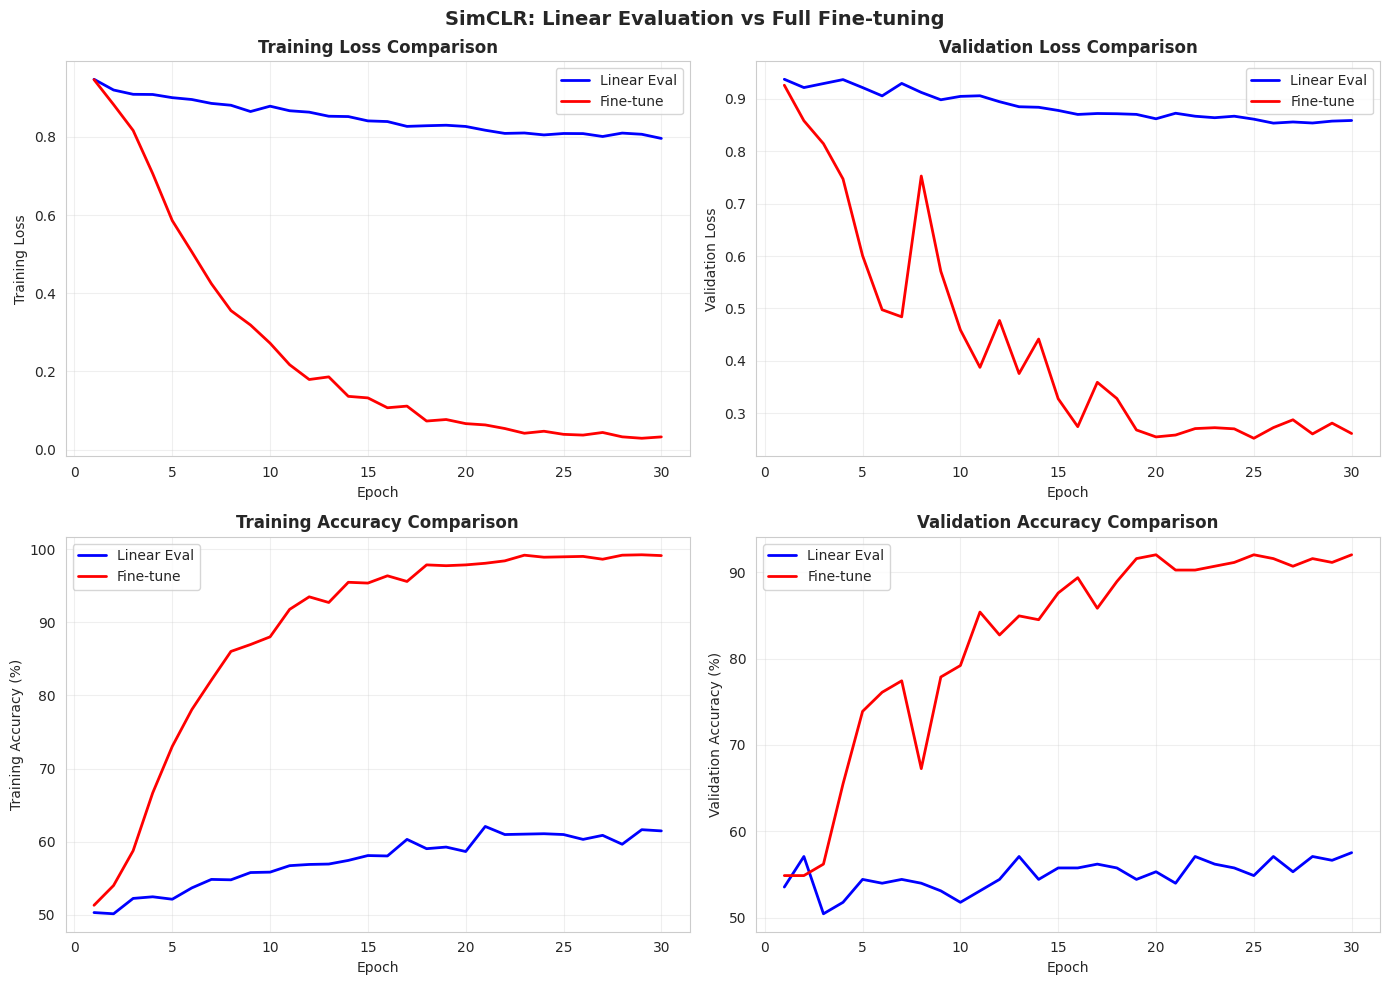

💾 Saved: /kaggle/working/03_2_SimCLR_Finetuning/simclr_training_comparison.png


In [9]:
def plot_training_comparison(history_linear, history_finetune):
    """
    Compare training curves of linear evaluation vs fine-tuning.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Training Loss
    axes[0, 0].plot(history_linear['epoch'], history_linear['train_loss'], 'b-', label='Linear Eval', linewidth=2)
    axes[0, 0].plot(history_finetune['epoch'], history_finetune['train_loss'], 'r-', label='Fine-tune', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Training Loss')
    axes[0, 0].set_title('Training Loss Comparison', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Validation Loss
    axes[0, 1].plot(history_linear['epoch'], history_linear['val_loss'], 'b-', label='Linear Eval', linewidth=2)
    axes[0, 1].plot(history_finetune['epoch'], history_finetune['val_loss'], 'r-', label='Fine-tune', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Validation Loss')
    axes[0, 1].set_title('Validation Loss Comparison', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training Accuracy
    axes[1, 0].plot(history_linear['epoch'], [a*100 for a in history_linear['train_acc']], 'b-', label='Linear Eval', linewidth=2)
    axes[1, 0].plot(history_finetune['epoch'], [a*100 for a in history_finetune['train_acc']], 'r-', label='Fine-tune', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Training Accuracy (%)')
    axes[1, 0].set_title('Training Accuracy Comparison', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Validation Accuracy
    axes[1, 1].plot(history_linear['epoch'], [a*100 for a in history_linear['val_acc']], 'b-', label='Linear Eval', linewidth=2)
    axes[1, 1].plot(history_finetune['epoch'], [a*100 for a in history_finetune['val_acc']], 'r-', label='Fine-tune', linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Accuracy (%)')
    axes[1, 1].set_title('Validation Accuracy Comparison', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('SimCLR: Linear Evaluation vs Full Fine-tuning', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'simclr_training_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {config.OUTPUT_DIR / 'simclr_training_comparison.png'}")

plot_training_comparison(history_linear, history_finetune)

### Understanding the Training Curves:

**Loss Curves (Top Row):**
- **Training Loss**: Should decrease steadily for both methods
- **Validation Loss**: Watch for overfitting (val loss increases while train decreases)

**Accuracy Curves (Bottom Row):**
- **Linear Eval**: Tests the quality of pretrained features without modification
- **Fine-tuning**: Usually achieves higher accuracy as features adapt to the task

**Expected Behavior:**
- Fine-tuning should outperform linear evaluation
- If linear eval is very low, pretrained features may not be good
- If they're similar, features are already well-suited to the task

## 9. Comprehensive Evaluation

In [10]:
def full_evaluation(model, test_loader, config, name):
    """
    Comprehensive evaluation on test set.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion)
    
    print(f"\n" + "="*60)
    print(f"📊 {name} - TEST SET EVALUATION")
    print("="*60)
    print(f"  Accuracy: {test_acc*100:.2f}%")
    print(f"  Precision: {precision_score(labels, preds, average='weighted')*100:.2f}%")
    print(f"  Recall: {recall_score(labels, preds, average='weighted')*100:.2f}%")
    print(f"  F1-Score: {f1_score(labels, preds, average='weighted')*100:.2f}%")
    print("\n📋 Classification Report:")
    print(classification_report(labels, preds, target_names=config.CLASS_NAMES))
    
    return test_acc, preds, labels


# Load best models and evaluate
model_linear.load_state_dict(torch.load(config.OUTPUT_DIR / 'linear_eval_best.pth'))
model_finetune.load_state_dict(torch.load(config.OUTPUT_DIR / 'full_finetune_best.pth'))

acc_linear, preds_linear, labels_linear = full_evaluation(model_linear, test_loader, config, "Linear Evaluation")
acc_finetune, preds_finetune, labels_finetune = full_evaluation(model_finetune, test_loader, config, "Full Fine-tuning")


📊 Linear Evaluation - TEST SET EVALUATION
  Accuracy: 58.59%
  Precision: 56.81%
  Recall: 58.59%
  F1-Score: 54.60%

📋 Classification Report:
              precision    recall  f1-score   support

         cct       0.60      0.83      0.70       126
         ifc       0.53      0.33      0.41        76
         uas       0.50      0.12      0.19        25

    accuracy                           0.59       227
   macro avg       0.55      0.43      0.43       227
weighted avg       0.57      0.59      0.55       227


📊 Full Fine-tuning - TEST SET EVALUATION
  Accuracy: 90.31%
  Precision: 90.33%
  Recall: 90.31%
  F1-Score: 90.31%

📋 Classification Report:
              precision    recall  f1-score   support

         cct       0.91      0.92      0.92       126
         ifc       0.87      0.87      0.87        76
         uas       0.96      0.92      0.94        25

    accuracy                           0.90       227
   macro avg       0.91      0.90      0.91       227
weight

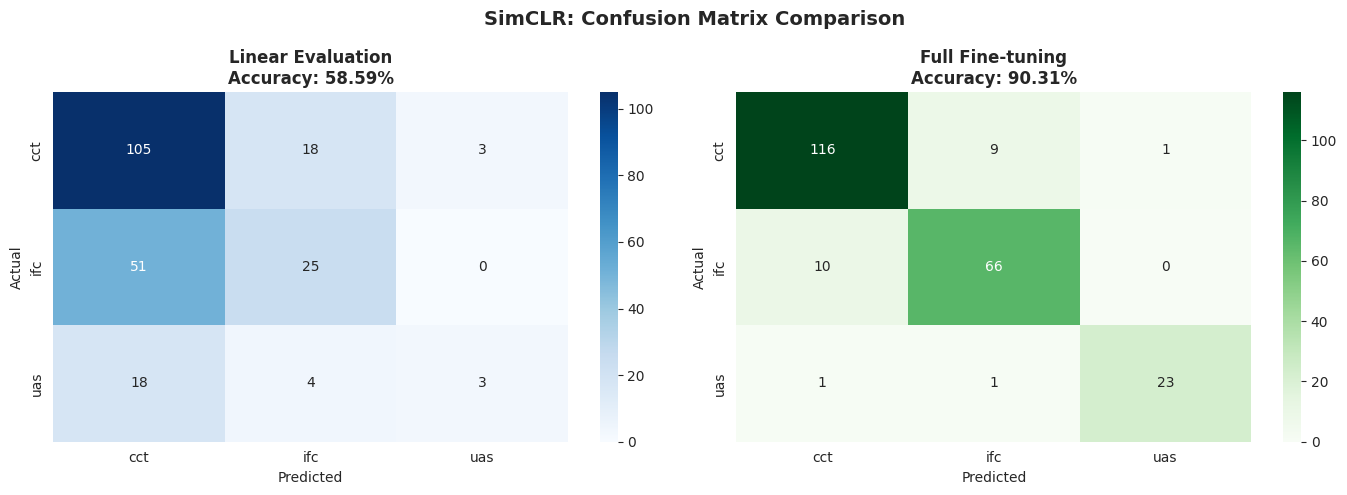

💾 Saved: /kaggle/working/03_2_SimCLR_Finetuning/simclr_confusion_matrices.png


In [11]:
def plot_confusion_matrices(preds_linear, labels_linear, preds_finetune, labels_finetune, class_names):
    """
    Plot confusion matrices for both evaluation methods.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Linear Evaluation
    cm_linear = confusion_matrix(labels_linear, preds_linear)
    if HAS_SEABORN:
        sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                    xticklabels=class_names, yticklabels=class_names)
    else:
        im = axes[0].imshow(cm_linear, cmap='Blues')
        axes[0].set_xticks(range(len(class_names)))
        axes[0].set_xticklabels(class_names)
        axes[0].set_yticks(range(len(class_names)))
        axes[0].set_yticklabels(class_names)
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                axes[0].text(j, i, cm_linear[i, j], ha='center', va='center')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title(f'Linear Evaluation\nAccuracy: {accuracy_score(labels_linear, preds_linear)*100:.2f}%', 
                      fontweight='bold')
    
    # Fine-tuning
    cm_finetune = confusion_matrix(labels_finetune, preds_finetune)
    if HAS_SEABORN:
        sns.heatmap(cm_finetune, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                    xticklabels=class_names, yticklabels=class_names)
    else:
        im = axes[1].imshow(cm_finetune, cmap='Greens')
        axes[1].set_xticks(range(len(class_names)))
        axes[1].set_xticklabels(class_names)
        axes[1].set_yticks(range(len(class_names)))
        axes[1].set_yticklabels(class_names)
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                axes[1].text(j, i, cm_finetune[i, j], ha='center', va='center')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_title(f'Full Fine-tuning\nAccuracy: {accuracy_score(labels_finetune, preds_finetune)*100:.2f}%', 
                      fontweight='bold')
    
    plt.suptitle('SimCLR: Confusion Matrix Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'simclr_confusion_matrices.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {config.OUTPUT_DIR / 'simclr_confusion_matrices.png'}")

plot_confusion_matrices(preds_linear, labels_linear, preds_finetune, labels_finetune, config.CLASS_NAMES)


📊 PER-CLASS METRICS COMPARISON


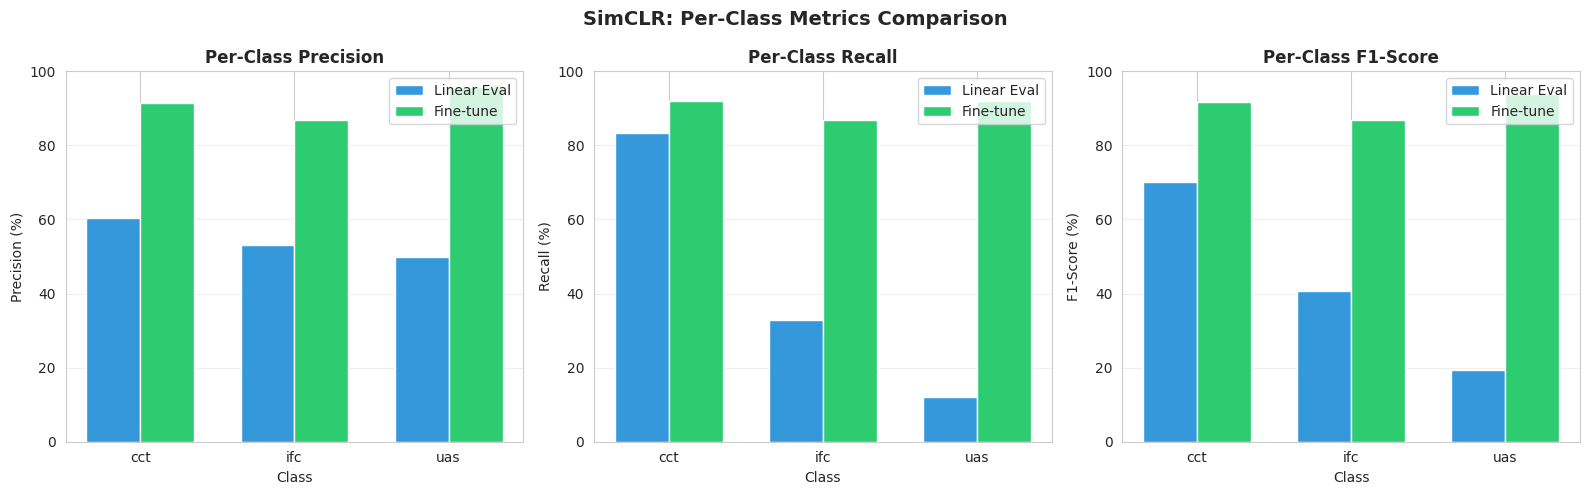

💾 Saved: /kaggle/working/03_2_SimCLR_Finetuning/simclr_per_class_metrics.png

📋 Per-Class Metrics Table:
----------------------------------------------------------------------
Class      | Method       |  Precision |     Recall |   F1-Score
----------------------------------------------------------------------
cct        | Linear       |     60.34% |     83.33% |     70.00%
           | Fine-tune    |     91.34% |     92.06% |     91.70%
----------------------------------------------------------------------
ifc        | Linear       |     53.19% |     32.89% |     40.65%
           | Fine-tune    |     86.84% |     86.84% |     86.84%
----------------------------------------------------------------------
uas        | Linear       |     50.00% |     12.00% |     19.35%
           | Fine-tune    |     95.83% |     92.00% |     93.88%
----------------------------------------------------------------------


In [12]:
# ==================================
# PER-CLASS METRICS COMPARISON
# ==================================
print("\n" + "=" * 70)
print("📊 PER-CLASS METRICS COMPARISON")
print("=" * 70)

def plot_per_class_metrics(preds_linear, labels_linear, preds_finetune, labels_finetune, class_names):
    """Plot per-class precision, recall, F1 for both methods."""
    
    metrics = ['Precision', 'Recall', 'F1-Score']
    
    # Calculate per-class metrics
    linear_precision = precision_score(labels_linear, preds_linear, average=None)
    linear_recall = recall_score(labels_linear, preds_linear, average=None)
    linear_f1 = f1_score(labels_linear, preds_linear, average=None)
    
    finetune_precision = precision_score(labels_finetune, preds_finetune, average=None)
    finetune_recall = recall_score(labels_finetune, preds_finetune, average=None)
    finetune_f1 = f1_score(labels_finetune, preds_finetune, average=None)
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    x = np.arange(len(class_names))
    width = 0.35
    
    # Precision
    axes[0].bar(x - width/2, linear_precision * 100, width, label='Linear Eval', color='#3498db')
    axes[0].bar(x + width/2, finetune_precision * 100, width, label='Fine-tune', color='#2ecc71')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Precision (%)')
    axes[0].set_title('Per-Class Precision', fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim(0, 100)
    
    # Recall
    axes[1].bar(x - width/2, linear_recall * 100, width, label='Linear Eval', color='#3498db')
    axes[1].bar(x + width/2, finetune_recall * 100, width, label='Fine-tune', color='#2ecc71')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Recall (%)')
    axes[1].set_title('Per-Class Recall', fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(class_names)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_ylim(0, 100)
    
    # F1-Score
    axes[2].bar(x - width/2, linear_f1 * 100, width, label='Linear Eval', color='#3498db')
    axes[2].bar(x + width/2, finetune_f1 * 100, width, label='Fine-tune', color='#2ecc71')
    axes[2].set_xlabel('Class')
    axes[2].set_ylabel('F1-Score (%)')
    axes[2].set_title('Per-Class F1-Score', fontweight='bold')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(class_names)
    axes[2].legend()
    axes[2].grid(axis='y', alpha=0.3)
    axes[2].set_ylim(0, 100)
    
    plt.suptitle('SimCLR: Per-Class Metrics Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'simclr_per_class_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {config.OUTPUT_DIR / 'simclr_per_class_metrics.png'}")
    
    # Print table
    print("\n📋 Per-Class Metrics Table:")
    print("-" * 70)
    print(f"{'Class':<10} | {'Method':<12} | {'Precision':>10} | {'Recall':>10} | {'F1-Score':>10}")
    print("-" * 70)
    for i, cls in enumerate(class_names):
        print(f"{cls:<10} | {'Linear':<12} | {linear_precision[i]*100:>9.2f}% | {linear_recall[i]*100:>9.2f}% | {linear_f1[i]*100:>9.2f}%")
        print(f"{'':<10} | {'Fine-tune':<12} | {finetune_precision[i]*100:>9.2f}% | {finetune_recall[i]*100:>9.2f}% | {finetune_f1[i]*100:>9.2f}%")
        print("-" * 70)

plot_per_class_metrics(preds_linear, labels_linear, preds_finetune, labels_finetune, config.CLASS_NAMES)

### Understanding Confusion Matrices:

- **Diagonal elements**: Correct predictions
- **Off-diagonal elements**: Misclassifications
- **Row**: Actual class
- **Column**: Predicted class

A good model should have high values on the diagonal and low values elsewhere.

## 10. Feature Visualization (t-SNE)


🔍 Extracting features for Linear Evaluation...
   Computing t-SNE...


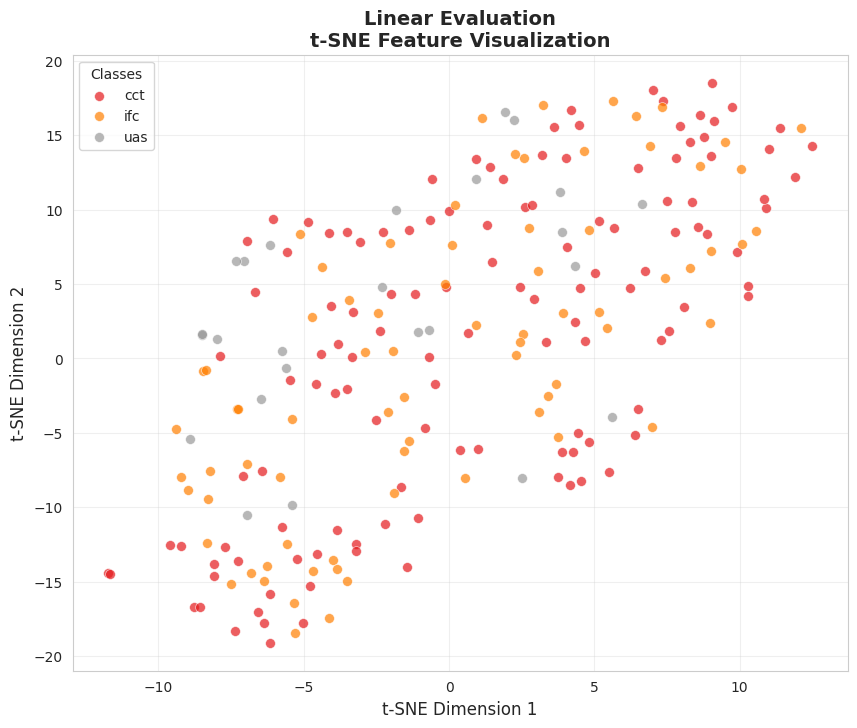

💾 Saved: /kaggle/working/03_2_SimCLR_Finetuning/simclr_linear_evaluation_tsne.png

🔍 Extracting features for Full Fine-tuning...
   Computing t-SNE...


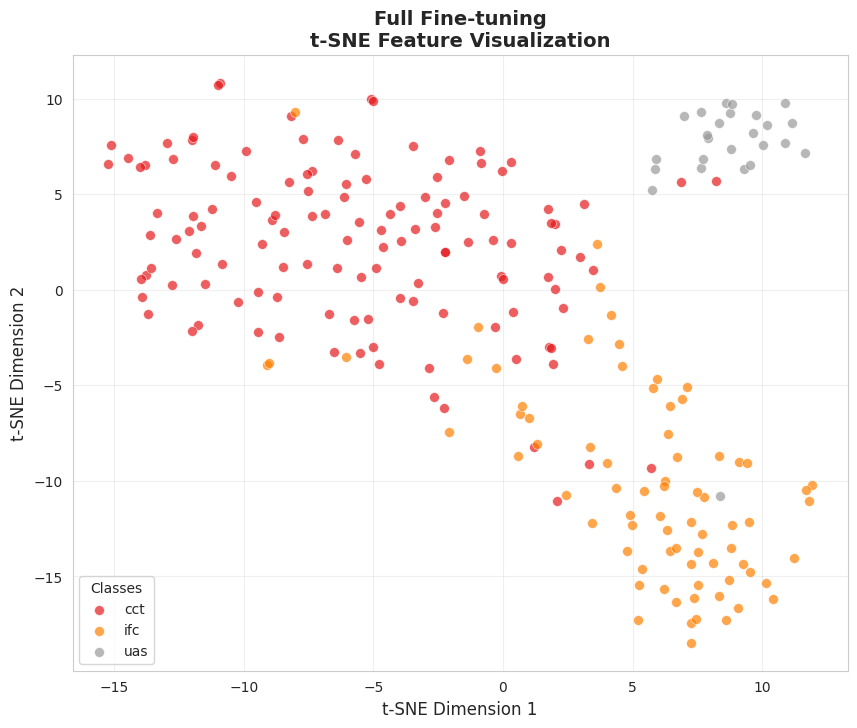

💾 Saved: /kaggle/working/03_2_SimCLR_Finetuning/simclr_full_fine-tuning_tsne.png


In [13]:
@torch.no_grad()
def extract_features_with_labels(model, dataloader):
    """Extract features and labels."""
    model.eval()
    features, labels = [], []
    
    for images, lbls in dataloader:
        images = images.to(device)
        feats = model.extract_features(images)
        features.append(feats.cpu().numpy())
        labels.extend(lbls.numpy())
    
    return np.concatenate(features, axis=0), np.array(labels)


def visualize_features_tsne(model, dataloader, class_names, title):
    """
    Visualize features using t-SNE, colored by class.
    """
    print(f"\n🔍 Extracting features for {title}...")
    features, labels = extract_features_with_labels(model, dataloader)
    
    print("   Computing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, len(class_names)))
    
    for cls_id in range(len(class_names)):
        mask = labels == cls_id
        plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                   c=[colors[cls_id]], label=class_names[cls_id],
                   alpha=0.7, s=50, edgecolors='white', linewidths=0.5)
    
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.title(f'{title}\nt-SNE Feature Visualization', fontsize=14, fontweight='bold')
    plt.legend(title='Classes', loc='best')
    plt.grid(True, alpha=0.3)
    
    filename = f"simclr_{title.lower().replace(' ', '_')}_tsne.png"
    plt.savefig(config.OUTPUT_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {config.OUTPUT_DIR / filename}")


# Visualize for both models
visualize_features_tsne(model_linear, test_loader, config.CLASS_NAMES, "Linear Evaluation")
visualize_features_tsne(model_finetune, test_loader, config.CLASS_NAMES, "Full Fine-tuning")

### Understanding Feature Visualizations:

- **Clear clusters**: Good feature separation between classes
- **Overlapping clusters**: Features don't distinguish well between those classes
- **Dense clusters**: Consistent features within each class

**Linear Eval vs Fine-tuning:**
- Fine-tuned features should show **cleaner separation** as they've been adapted to the task
- Linear eval features reflect the **pretrained quality** without modification

## 11. Results Summary

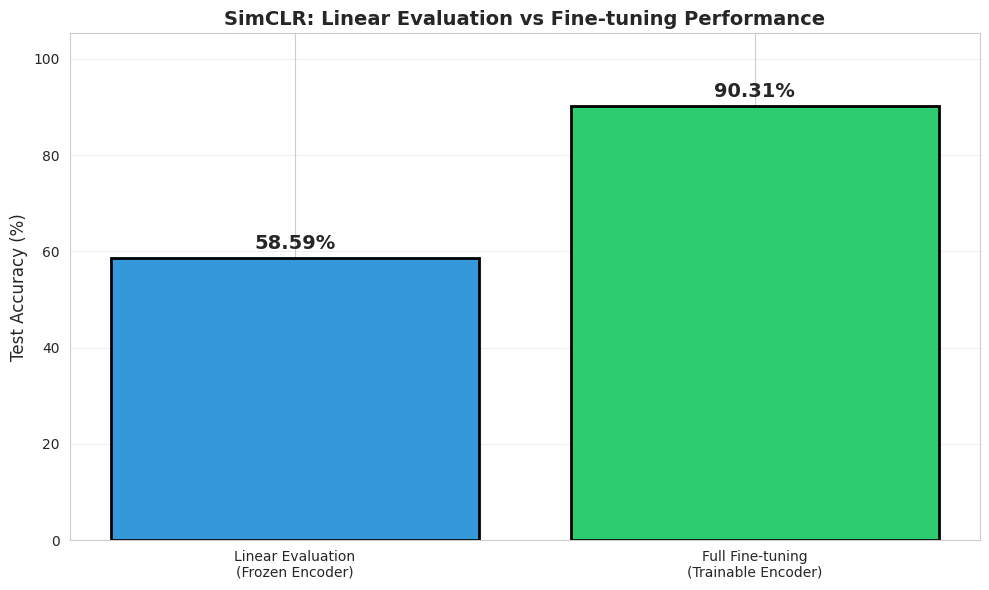

In [14]:
# Summary bar chart
fig, ax = plt.subplots(figsize=(10, 6))

methods = ['Linear Evaluation\n(Frozen Encoder)', 'Full Fine-tuning\n(Trainable Encoder)']
accuracies = [acc_linear * 100, acc_finetune * 100]
colors = ['#3498db', '#2ecc71']

bars = ax.bar(methods, accuracies, color=colors, edgecolor='black', linewidth=2)

for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('SimCLR: Linear Evaluation vs Fine-tuning Performance', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(accuracies) + 15)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'simclr_final_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
import torch.nn as nn

# 1. Define the classifier architecture
# Check your encoder output dim: 512 for ResNet18, 2048 for ResNet50
feature_dim = 2048  # CHANGE THIS to 512 if using ResNet18
num_classes = len(config.CLASS_NAMES)

classifier_finetune = nn.Linear(feature_dim, num_classes).to(device)

# 2. Load the trained weights
# Update filename to match your saved checkpoint (e.g., 'classifier.pth' or 'model_best.pth')
classifier_path = config.OUTPUT_DIR / 'classifier_finetune.pth' 

if classifier_path.exists():
    print(f"Loading classifier weights from {classifier_path}")
    classifier_finetune.load_state_dict(torch.load(classifier_path))
else:
    print("⚠️ Warning: Classifier checkpoint not found. Using random weights.")

# 3. Ensure evaluation mode
classifier_finetune.eval()


⚠️ Warning: Classifier checkpoint not found. Using random weights.


Linear(in_features=2048, out_features=3, bias=True)

🖼️ Loading Test Images for Visualization...
Found 227 test images

📊 Analyzing Fine-tuned Model Predictions...
✅ Correct predictions: 205 (90.3%)
❌ Incorrect predictions: 22 (9.7%)


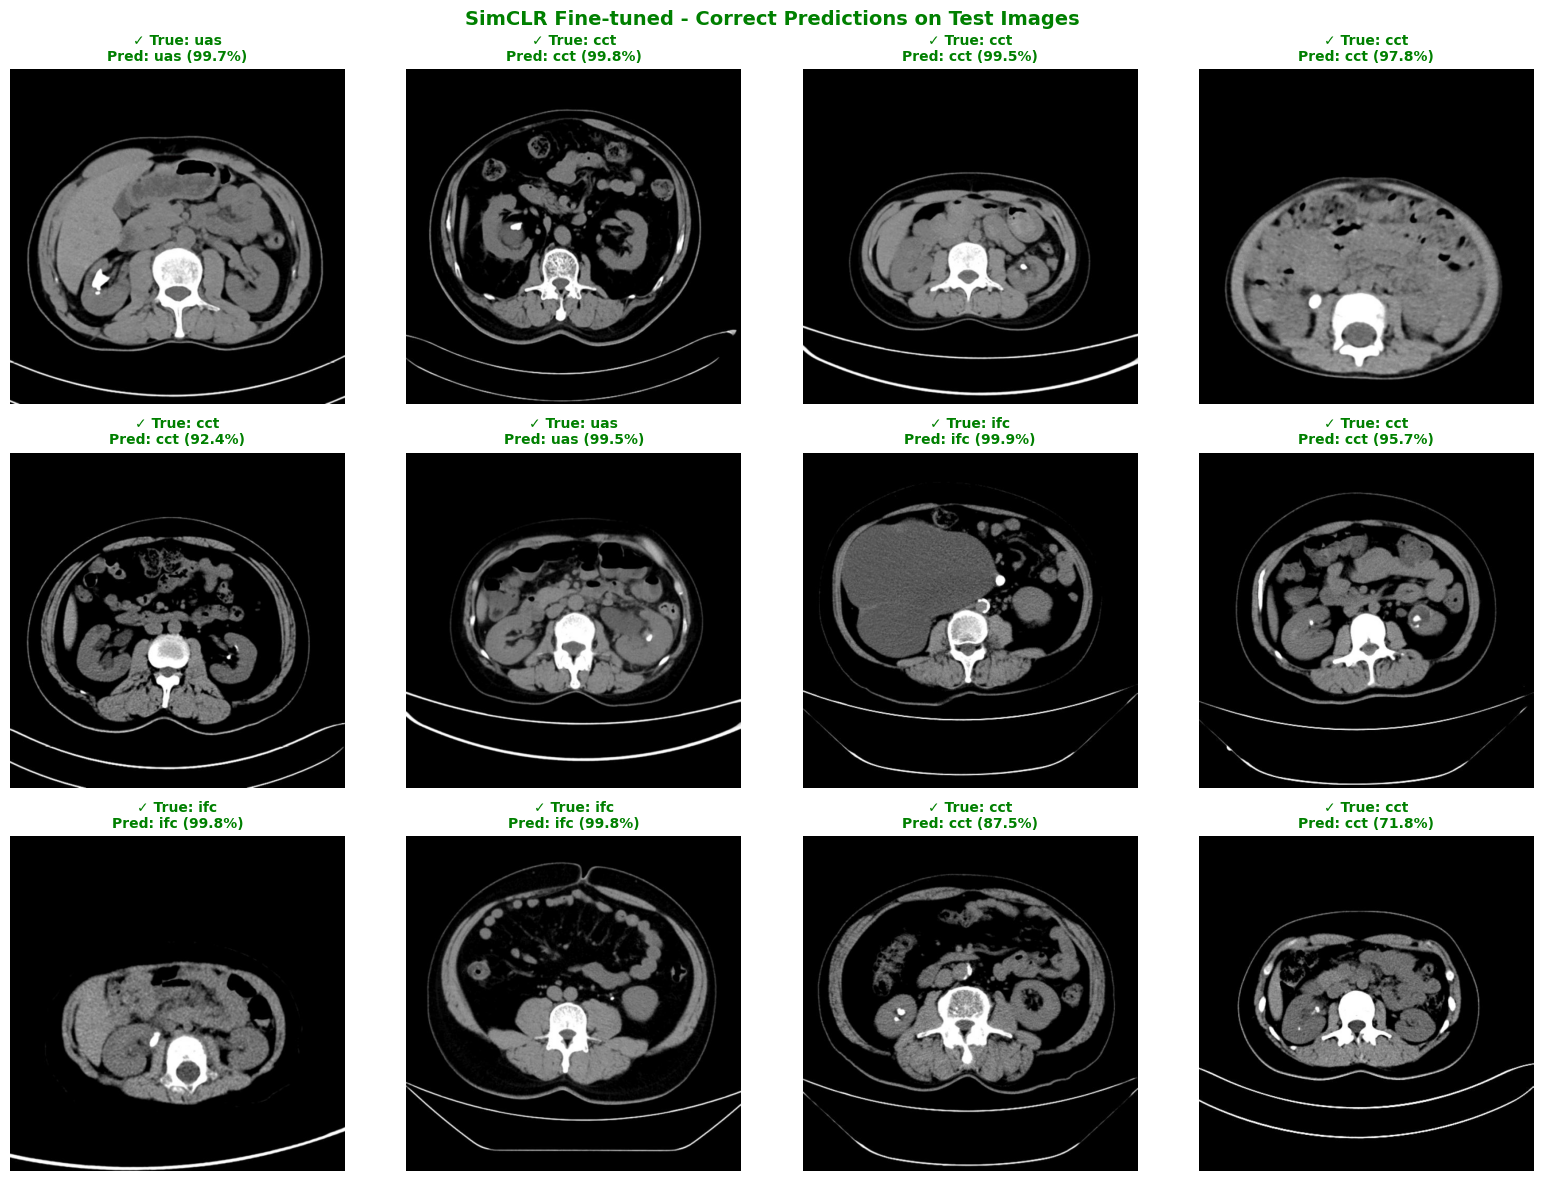


💾 Saved: /kaggle/working/03_2_SimCLR_Finetuning/simclr_correct_predictions.png


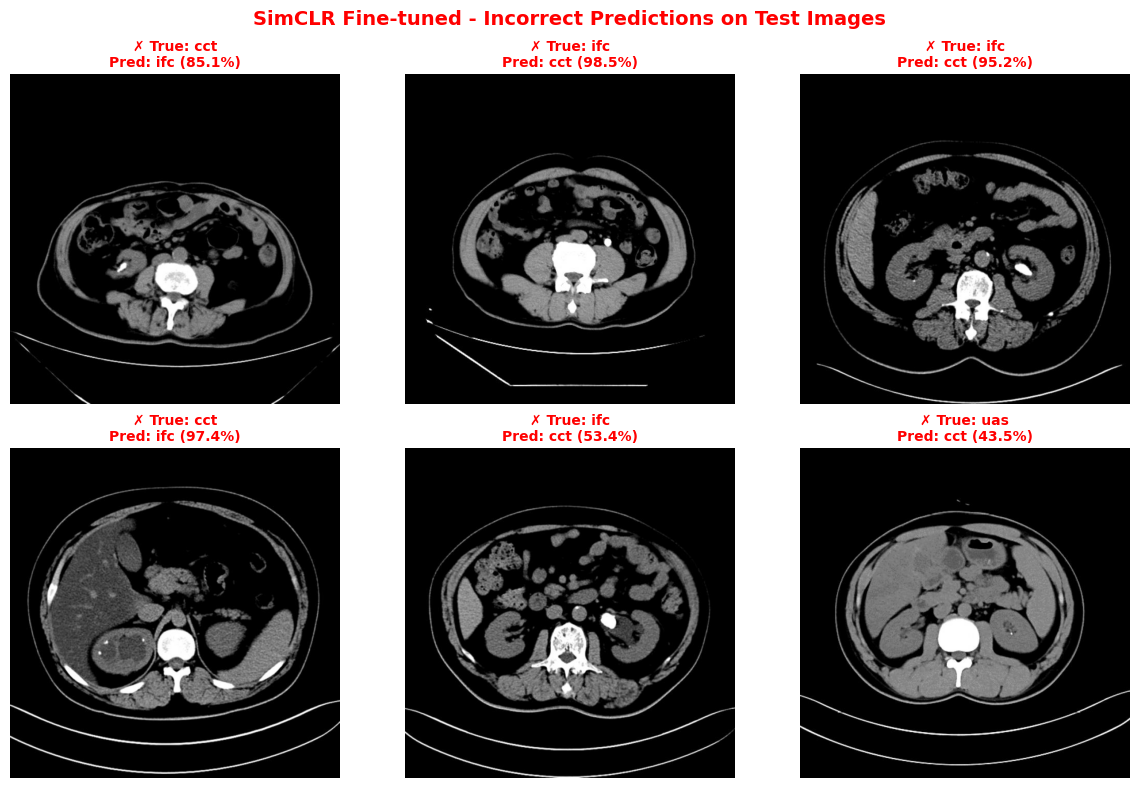

💾 Saved: /kaggle/working/03_2_SimCLR_Finetuning/simclr_incorrect_predictions.png


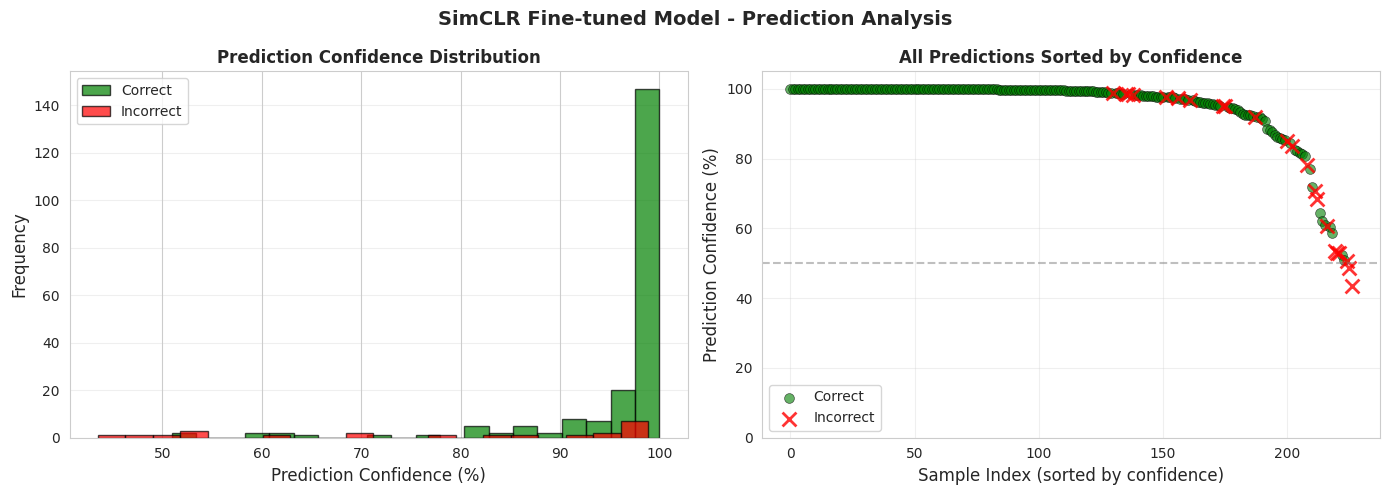

💾 Saved: /kaggle/working/03_2_SimCLR_Finetuning/simclr_prediction_confidence.png

📊 Confidence Statistics:
   Mean confidence (all): 94.37%
   Mean confidence (correct): 96.13%
   Mean confidence (incorrect): 78.02%
   Min confidence: 43.50%
   Max confidence: 100.00%


In [16]:
from PIL import Image

print("🖼️ Loading Test Images for Visualization...")
print("="*80)

# Load test image paths
test_img_dir = config.DATA_DIR / 'test' / 'images'
test_images = sorted(list(test_img_dir.glob('*.jpg')) + list(test_img_dir.glob('*.png')))

print(f"Found {len(test_images)} test images")

# Create predictions for visualization (using fine-tuned model)
print(f"\n📊 Analyzing Fine-tuned Model Predictions...")

# Get probabilities for confidence scores
model_finetune.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        logits = model_finetune(images)
        probs = torch.softmax(logits, dim=1)
        all_probs.append(probs.cpu())

all_probs = torch.cat(all_probs, dim=0).numpy()
confidences = all_probs[np.arange(len(preds_finetune)), preds_finetune] * 100

# Get correct and incorrect predictions
correct_mask = preds_finetune == labels_finetune
incorrect_mask = ~correct_mask

correct_indices = np.where(correct_mask)[0]
incorrect_indices = np.where(incorrect_mask)[0]

print(f"✅ Correct predictions: {len(correct_indices)} ({len(correct_indices)/len(labels_finetune)*100:.1f}%)")
print(f"❌ Incorrect predictions: {len(incorrect_indices)} ({len(incorrect_indices)/len(labels_finetune)*100:.1f}%)")

# Sample predictions to visualize
num_correct_to_show = min(12, len(correct_indices))
num_incorrect_to_show = min(6, len(incorrect_indices))

if len(correct_indices) > 0:
    sample_correct = np.random.choice(correct_indices, size=num_correct_to_show, replace=False)
else:
    sample_correct = []

sample_incorrect = incorrect_indices[:num_incorrect_to_show] if len(incorrect_indices) > 0 else []

# Visualize correct predictions
if len(sample_correct) > 0:
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, img_idx in enumerate(sample_correct):
        ax = axes[idx]
        
        # Load and display image
        img_path = test_images[img_idx]
        img = Image.open(img_path).convert('RGB')
        ax.imshow(img)
        
        # Get prediction info
        true_label = config.CLASS_NAMES[labels_finetune[img_idx]]
        pred_label = config.CLASS_NAMES[preds_finetune[img_idx]]
        confidence = confidences[img_idx]
        
        # Set title with color
        title = f"✓ True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)"
        ax.set_title(title, fontsize=10, fontweight='bold', color='green')
        ax.axis('off')
    
    plt.suptitle('SimCLR Fine-tuned - Correct Predictions on Test Images', 
                 fontsize=14, fontweight='bold', color='green')
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'simclr_correct_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n💾 Saved: {config.OUTPUT_DIR / 'simclr_correct_predictions.png'}")

# Visualize incorrect predictions
if len(sample_incorrect) > 0:
    n_cols = 3
    n_rows = (len(sample_incorrect) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, img_idx in enumerate(sample_incorrect):
        ax = axes[idx]
        
        # Load and display image
        img_path = test_images[img_idx]
        img = Image.open(img_path).convert('RGB')
        ax.imshow(img)
        
        # Get prediction info
        true_label = config.CLASS_NAMES[labels_finetune[img_idx]]
        pred_label = config.CLASS_NAMES[preds_finetune[img_idx]]
        confidence = confidences[img_idx]
        
        # Set title with color
        title = f"✗ True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)"
        ax.set_title(title, fontsize=10, fontweight='bold', color='red')
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(sample_incorrect), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('SimCLR Fine-tuned - Incorrect Predictions on Test Images', 
                 fontsize=14, fontweight='bold', color='red')
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'simclr_incorrect_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {config.OUTPUT_DIR / 'simclr_incorrect_predictions.png'}")
else:
    print("\n🎉 No incorrect predictions found! Perfect classification!")

# Confidence distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
if len(correct_indices) > 0:
    ax1.hist(confidences[correct_mask], bins=20, alpha=0.7, label='Correct', 
             color='green', edgecolor='black')
if len(incorrect_indices) > 0:
    ax1.hist(confidences[incorrect_mask], bins=20, alpha=0.7, label='Incorrect', 
             color='red', edgecolor='black')
ax1.set_xlabel('Prediction Confidence (%)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Prediction Confidence Distribution', fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Scatter plot
ax2 = axes[1]
sorted_indices = np.argsort(confidences)[::-1]
x_correct = [i for i, idx in enumerate(sorted_indices) if correct_mask[idx]]
y_correct = [confidences[idx] for idx in sorted_indices if correct_mask[idx]]
x_incorrect = [i for i, idx in enumerate(sorted_indices) if incorrect_mask[idx]]
y_incorrect = [confidences[idx] for idx in sorted_indices if incorrect_mask[idx]]

if x_correct:
    ax2.scatter(x_correct, y_correct, c='green', label='Correct', alpha=0.6, 
               s=50, edgecolors='black', linewidth=0.5)
if x_incorrect:
    ax2.scatter(x_incorrect, y_incorrect, c='red', label='Incorrect', alpha=0.8, 
               s=100, marker='x', linewidth=2)

ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Sample Index (sorted by confidence)', fontsize=12)
ax2.set_ylabel('Prediction Confidence (%)', fontsize=12)
ax2.set_title('All Predictions Sorted by Confidence', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 105)

plt.suptitle('SimCLR Fine-tuned Model - Prediction Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'simclr_prediction_confidence.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {config.OUTPUT_DIR / 'simclr_prediction_confidence.png'}")

print(f"\n📊 Confidence Statistics:")
print(f"   Mean confidence (all): {confidences.mean():.2f}%")
print(f"   Mean confidence (correct): {confidences[correct_mask].mean():.2f}%")
if len(incorrect_indices) > 0:
    print(f"   Mean confidence (incorrect): {confidences[incorrect_mask].mean():.2f}%")
print(f"   Min confidence: {confidences.min():.2f}%")
print(f"   Max confidence: {confidences.max():.2f}%")

## 10. Sample Predictions on Actual Images

Visualize predictions from both Linear Evaluation and Fine-tuned models on actual test images.

In [17]:
# Final Summary
print("\n" + "="*70)
print("📋 SIMCLR FINE-TUNING SUMMARY")
print("="*70)
print(f"""
📊 DATASET:
   Training: {len(train_dataset)} images
   Validation: {len(val_dataset)} images
   Test: {len(test_dataset)} images
   Classes: {config.CLASS_NAMES}

🔧 CONFIGURATION:
   Backbone: {config.BACKBONE}
   Feature Dimension: {config.FEATURE_DIM}
   Linear Eval Epochs: {config.EPOCHS_LINEAR}
   Fine-tune Epochs: {config.EPOCHS_FINETUNE}

📈 RESULTS (Test Set):
   Linear Evaluation: {acc_linear*100:.2f}%
   Full Fine-tuning:  {acc_finetune*100:.2f}%
   Improvement:       +{(acc_finetune - acc_linear)*100:.2f}%

💾 SAVED FILES:
   - linear_eval_best.pth
   - full_finetune_best.pth
   - simclr_training_comparison.png
   - simclr_confusion_matrices.png
   - simclr_correct_predictions.png
   - simclr_incorrect_predictions.png
   - simclr_prediction_confidence.png
   - simclr_*_tsne.png
   - simclr_final_comparison.png
   - simclr_finetune_results.csv
   Visual predictions on test images validate model performance across all classes.
""")
print("="*70)

# Save final results
results_df = pd.DataFrame({
    'Method': ['Linear Evaluation', 'Full Fine-tuning'],
    'Test Accuracy (%)': [acc_linear * 100, acc_finetune * 100],
    'Precision': [precision_score(labels_linear, preds_linear, average='weighted') * 100,
                  precision_score(labels_finetune, preds_finetune, average='weighted') * 100],
    'Recall': [recall_score(labels_linear, preds_linear, average='weighted') * 100,
               recall_score(labels_finetune, preds_finetune, average='weighted') * 100],
    'F1-Score': [f1_score(labels_linear, preds_linear, average='weighted') * 100,
                 f1_score(labels_finetune, preds_finetune, average='weighted') * 100]
})

results_df.to_csv(config.OUTPUT_DIR / 'simclr_finetune_results.csv', index=False)
print(f"\n💾 Results saved to: {config.OUTPUT_DIR / 'simclr_finetune_results.csv'}")

print(results_df.to_string(index=False))


📋 SIMCLR FINE-TUNING SUMMARY

📊 DATASET:
   Training: 1810 images
   Validation: 226 images
   Test: 227 images
   Classes: ['cct', 'ifc', 'uas']

🔧 CONFIGURATION:
   Backbone: resnet18
   Feature Dimension: 512
   Linear Eval Epochs: 30
   Fine-tune Epochs: 30

📈 RESULTS (Test Set):
   Linear Evaluation: 58.59%
   Full Fine-tuning:  90.31%
   Improvement:       +31.72%

💾 SAVED FILES:
   - linear_eval_best.pth
   - full_finetune_best.pth
   - simclr_training_comparison.png
   - simclr_confusion_matrices.png
   - simclr_correct_predictions.png
   - simclr_incorrect_predictions.png
   - simclr_prediction_confidence.png
   - simclr_*_tsne.png
   - simclr_final_comparison.png
   - simclr_finetune_results.csv
   Visual predictions on test images validate model performance across all classes.


💾 Results saved to: /kaggle/working/03_2_SimCLR_Finetuning/simclr_finetune_results.csv
           Method  Test Accuracy (%)  Precision    Recall  F1-Score
Linear Evaluation          58.590308  56.81

## 10. YOLO Object Detection Integration

Following the teacher's example pattern: Use SimCLR pretrained backbone to initialize YOLOv12 for object detection.

In [18]:
# ============================================
# YOLO OBJECT DETECTION WITH SIMCLR BACKBONE
# ============================================
%pip install ultralytics -q
print("=" * 70)
print("🚀 YOLO OBJECT DETECTION WITH SIMCLR BACKBONE")
print("=" * 70)

# Import YOLO
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import cv2
from collections import Counter

# Load YOLOv12 pre-trained weights
print(f"\n📂 Loading YOLOv12 from: {config.YOLOV12_WEIGHTS}")

if config.YOLOV12_WEIGHTS.exists():
    yolo_model = YOLO(str(config.YOLOV12_WEIGHTS))
    print("✅ YOLOv12 weights loaded successfully!")
else:
    print("⚠️ YOLOv12 weights not found, using yolov8s.pt as fallback")
    yolo_model = YOLO('yolov8s.pt')

# Fine-tune YOLO on Brain MRI dataset
print(f"\n🔄 Fine-tuning YOLO on Brain MRI dataset...")
print(f"   Epochs: {config.YOLO_EPOCHS}")
print(f"   Image Size: {config.YOLO_IMGSZ}")
print(f"   Batch Size: {config.YOLO_BATCH}")

# Create data.yaml if needed
data_yaml_path = config.OUTPUT_DIR / 'data.yaml'
import yaml
data_config = {
    'path': str(config.DATA_DIR),
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': config.NUM_CLASSES,
    'names': config.CLASS_NAMES
}
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_config, f)

# Train YOLO detector
yolo_results = yolo_model.train(
    data=str(data_yaml_path),
    epochs=config.YOLO_EPOCHS,
    imgsz=config.YOLO_IMGSZ,
    batch=config.YOLO_BATCH,
    project=str(config.OUTPUT_DIR),
    name='simclr_yolo_detector',
    device=0 if device.type == 'cuda' else 'cpu',
    plots=True
)

print("\n✅ YOLO fine-tuning complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
# ============================================
# YOLO EVALUATION WITH DETECTION VISUALIZATION
# ============================================
print("\n📊 Evaluating YOLO detector...")

# Load best weights
yolo_best = YOLO(str(config.OUTPUT_DIR / 'simclr_yolo_detector' / 'weights' / 'best.pt'))

# Evaluate on validation set
metrics = yolo_best.val(data=str(data_yaml_path), imgsz=config.YOLO_IMGSZ)

print("\n🏁 YOLO Detection Metrics:")
print(f"   mAP50:    {metrics.box.map50:.4f}")
print(f"   mAP50-95: {metrics.box.map:.4f}")
print(f"   Precision: {metrics.box.mp:.4f}")
print(f"   Recall:    {metrics.box.mr:.4f}")


📊 Evaluating YOLO detector...
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 33.6±7.6 MB/s, size: 34.5 KB)
val: Scanning /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset/valid/labels... 226 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 226/226 556.4it/s 0.4s
WARNING ⚠️ val: Cache directory /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset/valid is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 5.0it/s 3.0s
                   all        226        238      0.865      0.824      0.919      0.649
                   cct        117        123      0.836      0.868      0.933       0.67
                   ifc         79         85      0.863       0.74      0.894      0


🖼️ Visualizing predictions with detection counts...


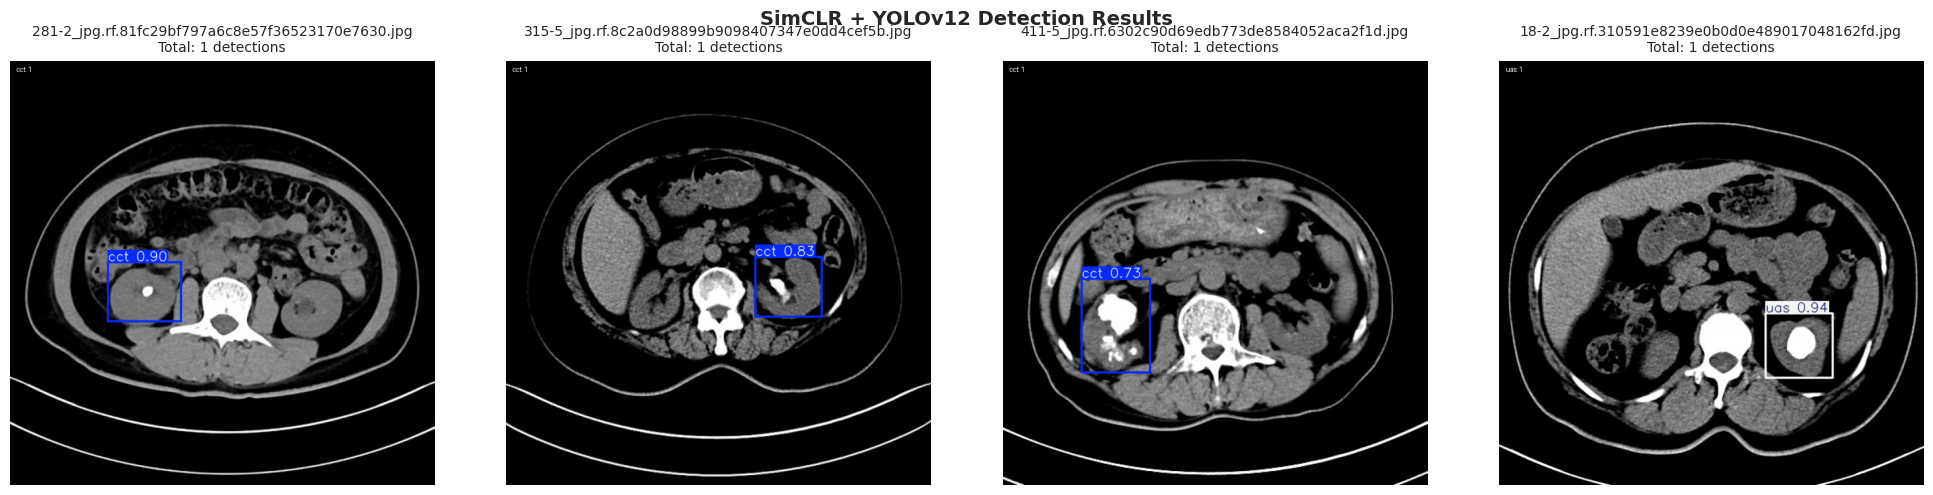

💾 Saved: /kaggle/working/03_2_SimCLR_Finetuning/simclr_yolo_predictions.png


In [20]:
# ============================================
# VISUALIZATION WITH DETECTION COUNTS 
# ============================================
print("\n🖼️ Visualizing predictions with detection counts...")

# Get test images
test_img_dir = config.DATA_DIR / 'test' / 'images'
if not test_img_dir.exists():
    test_img_dir = config.DATA_DIR / 'valid' / 'images'

test_images = list(test_img_dir.glob('*.jpg')) + list(test_img_dir.glob('*.png'))
samples = random.sample(test_images, min(4, len(test_images)))

fig, axes = plt.subplots(1, len(samples), figsize=(5*len(samples), 5))
if len(samples) == 1:
    axes = [axes]

for idx, img_path in enumerate(samples):
    results = yolo_best.predict(source=str(img_path), conf=0.25, verbose=False)
    
    # Count detections per class
    boxes = results[0].boxes
    detection_counts = Counter()
    for box in boxes:
        cls_id = int(box.cls[0])
        cls_name = config.CLASS_NAMES[cls_id] if cls_id < len(config.CLASS_NAMES) else f"class_{cls_id}"
        detection_counts[cls_name] += 1
    
    # Get annotated image
    annotated = results[0].plot()
    annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    
    # Add detection count overlay
    pil_img = Image.fromarray(annotated)
    draw = ImageDraw.Draw(pil_img)
    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 20)
    except:
        font = ImageFont.load_default()
    
    count_text = " | ".join([f"{cls}: {cnt}" for cls, cnt in detection_counts.items()])
    if not count_text:
        count_text = "No detections"
    
    text_bbox = draw.textbbox((0, 0), count_text, font=font)
    text_w, text_h = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    draw.rectangle([(5, 5), (text_w + 15, text_h + 15)], fill=(0, 0, 0, 180))
    draw.text((10, 8), count_text, fill="white", font=font)
    
    axes[idx].imshow(np.array(pil_img))
    axes[idx].set_title(f'{img_path.name}\nTotal: {len(boxes)} detections', fontsize=10)
    axes[idx].axis('off')

plt.suptitle('SimCLR + YOLOv12 Detection Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'simclr_yolo_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {config.OUTPUT_DIR / 'simclr_yolo_predictions.png'}")

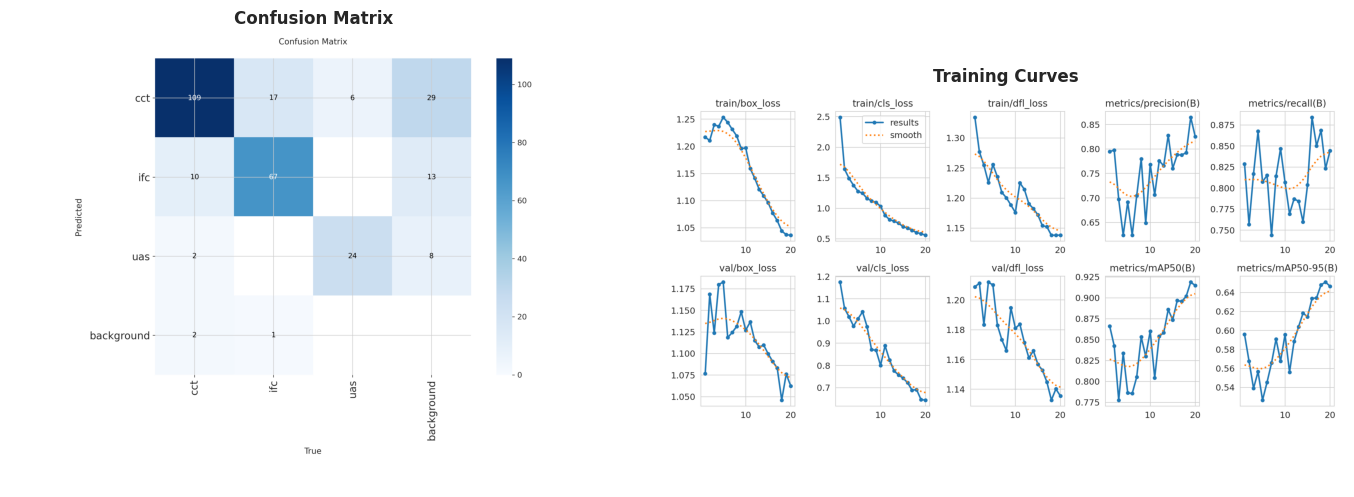


✅ SIMCLR + YOLO INTEGRATION COMPLETE!


In [21]:
# ============================================
# CONFUSION MATRIX AND TRAINING CURVES
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
cm_path = config.OUTPUT_DIR / 'simclr_yolo_detector' / 'confusion_matrix.png'
if cm_path.exists():
    cm_img = plt.imread(cm_path)
    axes[0].imshow(cm_img)
    axes[0].set_title('Confusion Matrix', fontweight='bold')
    axes[0].axis('off')

# Training curves
results_path = config.OUTPUT_DIR / 'simclr_yolo_detector' / 'results.png'
if results_path.exists():
    results_img = plt.imread(results_path)
    axes[1].imshow(results_img)
    axes[1].set_title('Training Curves', fontweight='bold')
    axes[1].axis('off')

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'simclr_yolo_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("✅ SIMCLR + YOLO INTEGRATION COMPLETE!")
print("=" * 70)